In [1]:
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import time

# Initialize session
spark_session = SparkSession.builder\
    .master("spark://192.168.2.156:7077")\
    .appName("project-group-34-1m")\
    .config("spark.executor.memory", "8g")\
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.cores", "2")\
    .config("spark.dynamicAllocation.enabled", True)\
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True)\
    .config("spark.shuffle.service.enabled", False)\
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s")\
    .config("spark.driver.host", "192.168.2.162")\
    .config("spark.cores.max", 8)\
    .getOrCreate()

spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/19 23:30:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# PREPROCESSING
start_total = time.time()
start_pre = time.time()

# Read data
df = spark_session.read.json("hdfs://192.168.2.156:9000/data/reddit/corpus-webis-tldr-17.json")\
    .select("summary")\
    .filter(col("summary").isNotNull())\
    .limit(1000000)

# Show dataframe and total filtered rows
df = df.cache()
df.show(5)
print(f"of total {df.count()} rows")

# Print preprocessing time
end_pre = time.time()
time_pre = end_pre-start_pre
print(f"Preprocessing time: {round((time_pre)/60)} minutes ({round(time_pre)} seconds)")

+--------------------+
|             summary|
+--------------------+
|Stop trying to pi...|
|You aren't really...|
|is: the galaxy is...|
|Big ships are not...|
|No fuck you read it.|
+--------------------+
only showing top 5 rows

of total 1000000 rows
Preprocessing time: 2 minutes (96 seconds)


In [3]:
# LABELING
start_label = time.time()

# Add sentiment file to spark cluster
spark_context.addPyFile("hdfs://192.168.2.162:9000/user/ubuntu/vaderSentiment.zip")

# Analyzer
analyzer = SentimentIntensityAnalyzer()

# Get sentiment scores
def get_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    return 2 if score > 0.05 else 0 if score < -0.05 else 1

# Compute sentiment scores
sentiment_udf = udf(get_sentiment, IntegerType())

# Store results in new column 
df = df.withColumn("sentiment", sentiment_udf(col("summary")))
df = df.cache()

# Show dataframe
df.show(5)

# Print labeling time
end_label = time.time()
time_label = end_label-start_label
print(f"Labeling time: {round((time_label)/60)} minutes ({round(time_label)} seconds)")

[Stage 8:>                                                          (0 + 1) / 1]

+--------------------+---------+
|             summary|sentiment|
+--------------------+---------+
|Stop trying to pi...|        0|
|You aren't really...|        2|
|is: the galaxy is...|        2|
|Big ships are not...|        1|
|No fuck you read it.|        2|
+--------------------+---------+
only showing top 5 rows

Labeling time: 4 minutes (234 seconds)


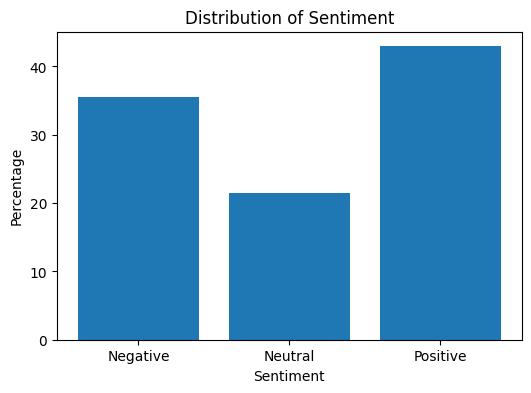

In [4]:
# Visulize sentiment distribution
# Compute sentiment share
sentiment_counts = df.groupBy("sentiment").count().toPandas().sort_values("sentiment")
sentiment_counts["percentage"] = (sentiment_counts["count"] / sentiment_counts["count"].sum()) * 100

# Plot distribution
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts["sentiment"], sentiment_counts["percentage"])
plt.xticks(sentiment_counts["sentiment"], ["Negative", "Neutral", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Percentage")
plt.title("Distribution of Sentiment")
plt.show()

In [5]:
# MODEL DEVELOPMENT
start_model = time.time()

# Split lines into words
tokenizer = RegexTokenizer(inputCol="summary", outputCol="words", pattern="\\W")

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Convert words into numbers
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=5000, minDF=5)
#vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=5000, minDF=5)

# Define model
lr = LogisticRegression(featuresCol="features", labelCol="sentiment")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, lr])
#pipeline = Pipeline(stages=[tokenizer, vectorizer, lr])

# Split data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
train_data = train_data.cache()
test_data = test_data.cache()

# Train model
start_train = time.time()
model = pipeline.fit(train_data)
end_train = time.time()

# Make predictions
predictions = model.transform(test_data)

# Show predictions
predictions.select("summary", "sentiment", "prediction").show(5)

# Print training and modeling time
end_model = time.time()
time_model = end_model-start_model
time_train = end_train-start_train
print(f"Training time: {round((time_train)/60)} minutes ({round(time_train)} seconds)")
print(f"Modeling time: {round((time_model)/60)} minutes ({round(time_model)} seconds)")

[Stage 159:>                                                        (0 + 1) / 1]

+--------------------+---------+----------+
|             summary|sentiment|prediction|
+--------------------+---------+----------+
|                   0|        1|       1.0|
|0 < #femme les < ...|        2|       2.0|
|0 <===8      --> ...|        1|       1.0|
|0 Knowledge  of p...|        0|       2.0|
|0 evidence of any...|        0|       0.0|
+--------------------+---------+----------+
only showing top 5 rows

Training time: 14 minutes (832 seconds)
Modeling time: 14 minutes (835 seconds)


In [6]:
# MODEL EVALUATION
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction")

metrics = {"Accuracy": round(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}), 4),
           "Precision": round(evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}), 4),
           "Recall": round(evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}), 4),
           "F1": round(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}), 4)}

metrics

{'Accuracy': 0.8434, 'Precision': 0.8433, 'Recall': 0.8434, 'F1': 0.8429}

In [7]:
# Total execution time
end_total = time.time()
time_total = end_total-start_total
print(f"Total execution time: {round((time_total)/60)} minutes ({round(time_total)} seconds)")

Total execution time: 20 minutes (1200 seconds)


In [8]:
# Terminate session
spark_session.stop()